In [58]:
! pip install --upgrade imutils
import numpy as np
import struct
import os
import array
import cv2
import matplotlib.pylab as plt
from IPython.display import clear_output
from scipy.signal import savgol_filter
from time import sleep
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import numpy as np
import imutils
import time

Requirement already up-to-date: imutils in /opt/conda/lib/python3.6/site-packages (0.5.3)
You are using pip version 18.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [50]:
path ="../input/data2/data/seq-P04-M04-A0001-G01-C00-S0033/seq-P04-M04-A0001-G01-C00-S0033.gt"
path1="../input/data2/data/seq-P04-M04-A0001-G01-C00-S0033/seq-P04-M04-A0001-G01-C00-S0033.z16"
#path="../input/data2/data/seq-P08-M02-A0001-G02-C00-S0029/seq-P08-M02-A0001-G02-C00-S0029.gt"
#path1="../input/data2/data/seq-P08-M02-A0001-G02-C00-S0029/seq-P08-M02-A0001-G02-C00-S0029.z16"

In [51]:
size = 512*424
file = None

In [52]:
def displayx(img,title,show):
    if show==0 :
        return
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(title) 
    plt.show()

In [65]:
def getFrame(frame,size=512*424):
    arr=[]
    global file
    if file is None:
          file= open(path1, "rb")
    file.seek(size*2*frame)
    buffer = file.read()
    return buffer
   

In [67]:
def readBuffer(buffer):
    outx = np.frombuffer(buffer,dtype=np.int16,count=size).reshape(424,512)
    out = np.uint8(outx * (255 / np.max(outx)))
    out = 255-out
    out[out>240] =0
    out[out<80] = 0
    return out
    

In [60]:
kernel_size=25
kernel = np.ones((kernel_size,kernel_size),np.uint8)
kernel2 = np.ones((9,9),np.uint8)

def findHead(image,kernel_size=25,thresh_rem=248, show= 0):
    
    #Get the binary mask
    thresh = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    displayx(thresh,"mask",show)
    thresh[thresh==255]=1
    
    #Apply dilate op-> replace all the values with local maximaum
    dilated = cv2.dilate(image,kernel,iterations=4)
    displayx(dilated,"dilated",show)
    
    #Aplly mask on dilated image
    res= dilated*thresh
    displayx(res,"final dilated",show)
    
    #Subtract the dilated image from original->the local maxima valuea will be ~= 0
    res= res-image
    displayx(res,"",show)
    #replace the unmasked values with max so that we get boundary of maxima
    res[thresh==0]=255
    displayx(res,"",show)
   
    #Inverse the image-> maxima become highlighted
    res= 255-res
    displayx(res,"",show)
    
    #Apply threshold to extract just the maxima(top values)
    res[res< thresh_rem] =0
    displayx(res,"",show)
    
    #Apply closing operation to remove holes from the max values
    res= cv2.morphologyEx(res, cv2.MORPH_CLOSE, kernel2)
    
    displayx(res,"final",show)
    return res

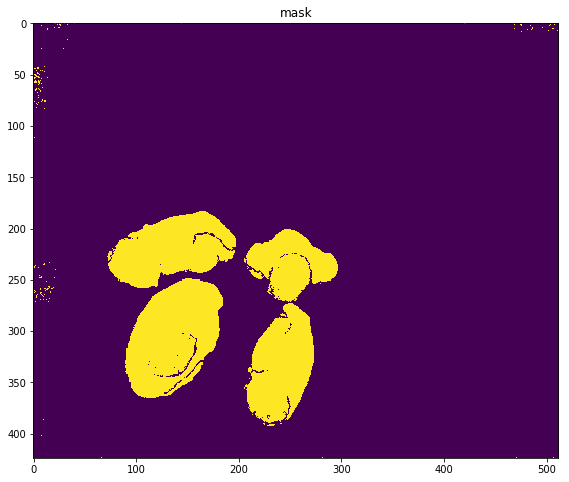

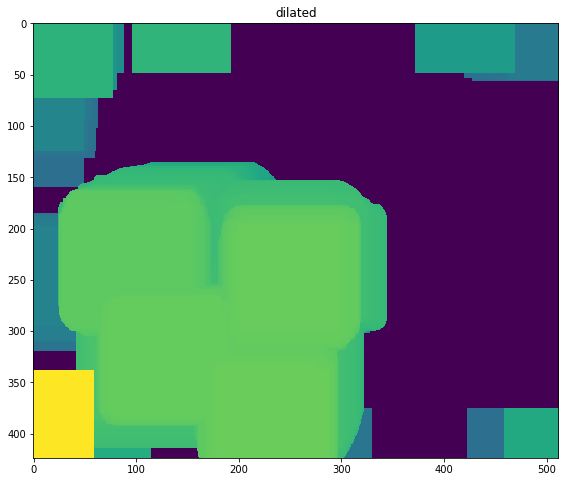

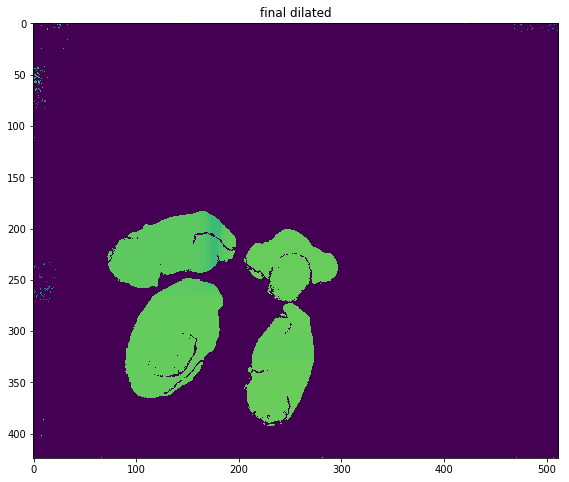

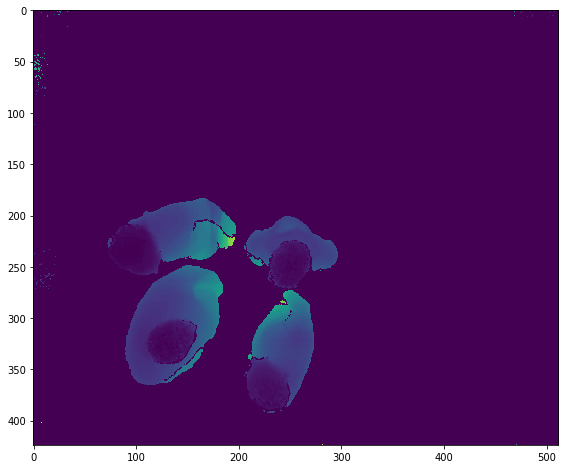

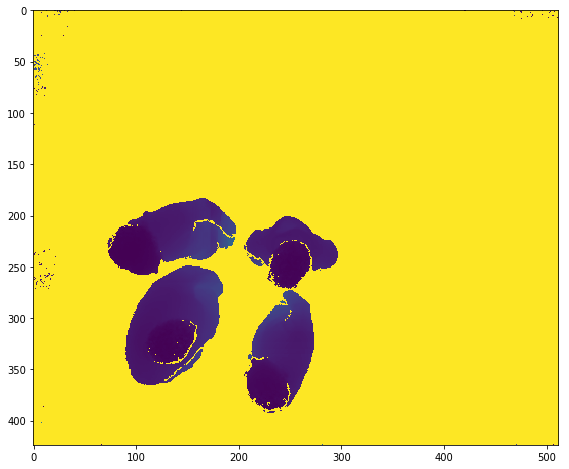

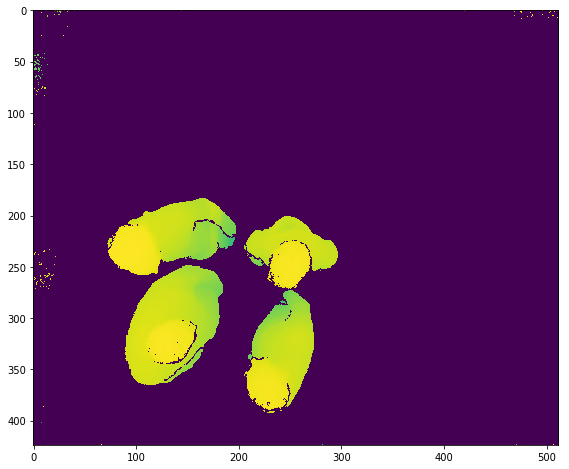

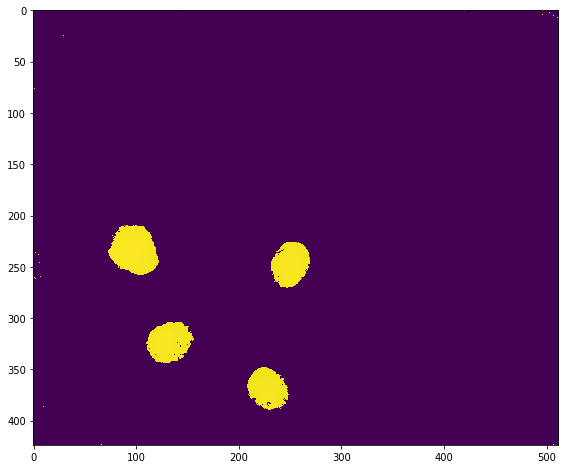

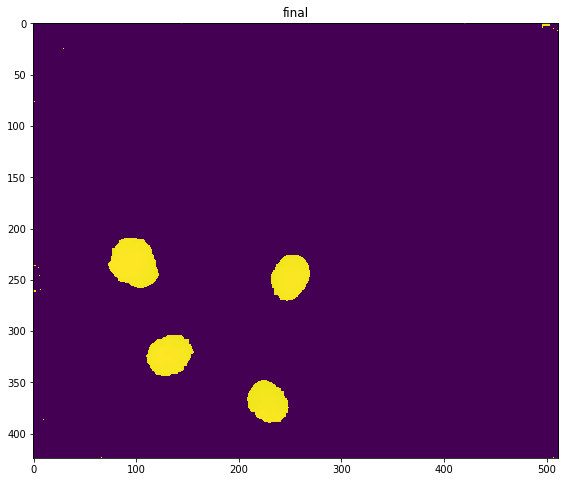

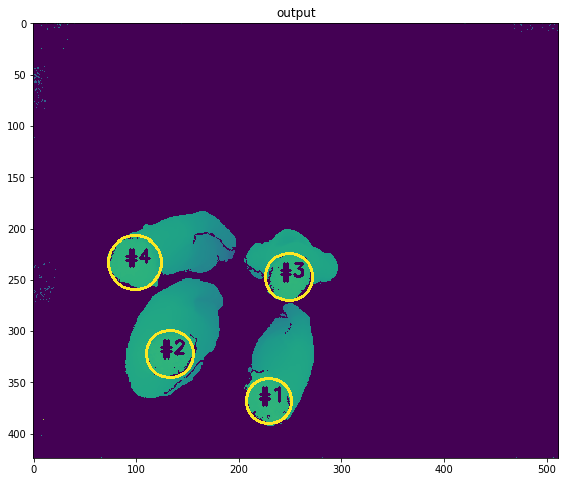

In [68]:
for i in range (300,301):
    #print(i)
    buffer=getFrame(i)
    out = readBuffer(buffer)
    final=findHead(out,show =1)
    
    #Get all Contours
    cnts = cv2.findContours(final.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    contours=[]
    
    #Extract larges contours by area-> our heads
    for cnt in cnts:
        area = cv2.contourArea(cnt)
        if area > 300:
            #print(area)
            contours.append(cnt)
        
   
    count = 0
    
    #Draw comtours
    for c in contours:
        count = count + 1
        ((x, y), r) = cv2.minEnclosingCircle(c)
        cv2.circle(out, (int(x), int(y)), int(r), (255, 255, 255), 2)
        cv2.putText(out, "#{}".format(str(count)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
    # Display output
    displayx(out,"output",1)
   
    clear_output(wait=True)

In [70]:
#Runtime Analysis
counter = 0
timeCounter=0
runtimes = []
for i in range (100,301):
    counter +=1
    #print(i)
    buffer=getFrame(i)
    
    start = time.time()
    
    out = readBuffer(buffer)  
    final=findHead(out,show =0)
    
    #Get all Contours
    cnts = cv2.findContours(final.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    contours=[]
    
    #Extract larges contours by area-> our heads
    for cnt in cnts:
        area = cv2.contourArea(cnt)
        if area > 300:
            #print(area)
            contours.append(cnt)
            
    duration = time.time()-start 
    timeCounter += duration
    runtimes.append(duration)   
   #count = 0
print('FPS',counter/timeCounter)  
#     #Draw comtours
#     for c in contours:
#         count = count + 1
#         ((x, y), r) = cv2.minEnclosingCircle(c)
#         cv2.circle(out, (int(x), int(y)), int(r), (255, 255, 255), 2)
#         cv2.putText(out, "#{}".format(str(count)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        
#     # Display output
#     displayx(out,"output",1)
   
#     clear_output(wait=True)
print("{} runs with batch size {}".format(counter, 1))
print("Mean: {}".format(np.mean(runtimes)))
print("Median: {}".format(np.median(runtimes)))
print("Min: {}".format(np.min(runtimes)))
print("Max: {}".format(np.max(runtimes)))
print("Std: {}".format(np.std(runtimes)))
print("Avg. imgs per sec: {}".format(counter/ np.sum(runtimes)))

FPS 178.64796360990243
201 runs with batch size 1
Mean: 0.005597600889443165
Median: 0.005459785461425781
Min: 0.005270481109619141
Max: 0.008016586303710938
Std: 0.00034584594127117944
Avg. imgs per sec: 178.64796360990243
